[colab](https://colab.research.google.com/github/rufous86/studies/blob/main/DLS_NLP/04_text_classification_with_RNN/hw_text_classification.ipynb)

# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [33]:
!pip install datasets -q

Импорт необходимых библиотек

In [34]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [35]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части. 

In [37]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

  0%|          | 0/2 [00:00<?, ?it/s]

In [38]:
dataset['train']['text'][0]

"Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [39]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [40]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ] 
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])
    
    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [41]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [42]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])
    
    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна. 

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие. 

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно. 

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее. 
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству. 

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты. 
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет. 
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная? 
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

In [43]:
def train(model, num_epoch):
    '''
    returns losses, acc
    '''
    num_epoch = num_epoch
    eval_steps = len(train_dataloader) // 2

    losses = []
    acc = []

    model = model.to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()
        
        losses.append(sum(epoch_losses) / len(epoch_losses))
        print(f'loss: {losses[-1]:.3f}, acc: {acc[-1]:.3f}')
    return losses, acc

In [44]:
def plot_results(losses, acc):
    plt.plot(np.arange(len(losses[1:])), losses[1:], label='loss')

    plt.title('Losses')
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

    plt.plot(np.arange(len(acc[1:])), acc[1:], label='accuracy')

    plt.title('Accuracy')
    plt.xlabel("epoch")
    plt.legend()
    plt.show()
    print(f"Лучшая accuracy: {(max(acc) * 100):.2f}")

## Запуск базовой модели с семинара на новом датасете (1 балл)

In [45]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        num_layers: int = 1, aggregation_type: str = 'max',
        rnn = nn.RNN
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = rnn(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]
        # !!! output is logit!!!
        # loss CrossEntropyLoss works with logits (in comparison to NLL loss)

        return prediction

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.407, acc: 0.868


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.277, acc: 0.889


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.247, acc: 0.899


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.221, acc: 0.905


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.200, acc: 0.896


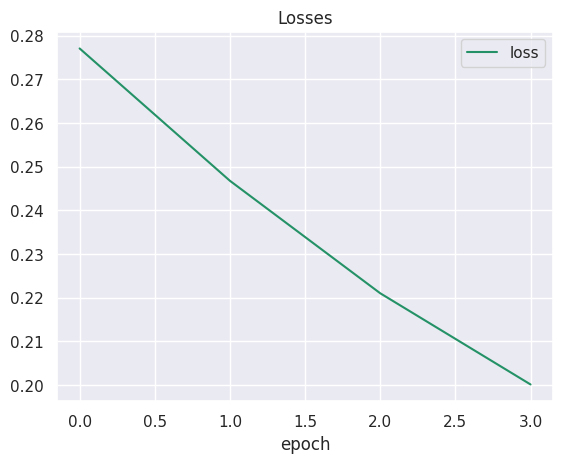

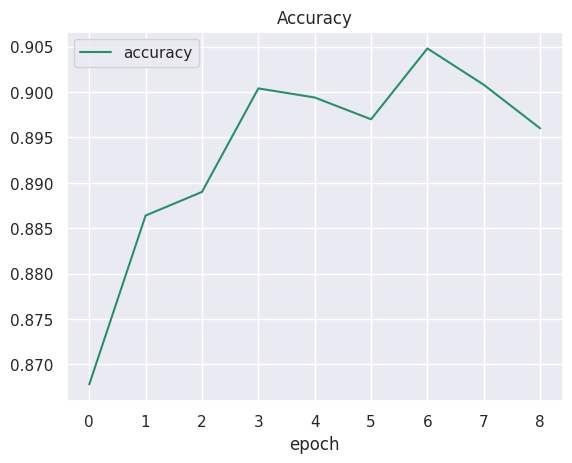

Лучшая accuracy: 90.48


In [46]:
model_base = CharLM(
        hidden_dim=256, 
        vocab_size=len(vocab), 
        num_layers=1,
        aggregation_type='max',
        rnn=nn.RNN)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_base.parameters())

losses, acc = train(model_base, num_epoch=5)
plot_results(losses, acc)

## Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)

### Вариант 1. Увеличение количества рекуррентных слоев модели

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.466, acc: 0.855


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.296, acc: 0.897


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.256, acc: 0.904


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.232, acc: 0.899


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.216, acc: 0.904


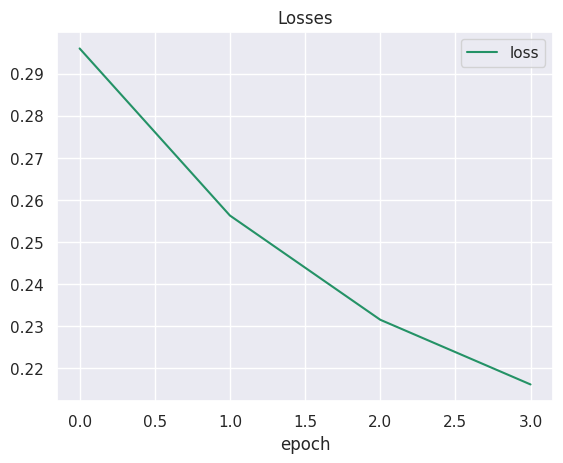

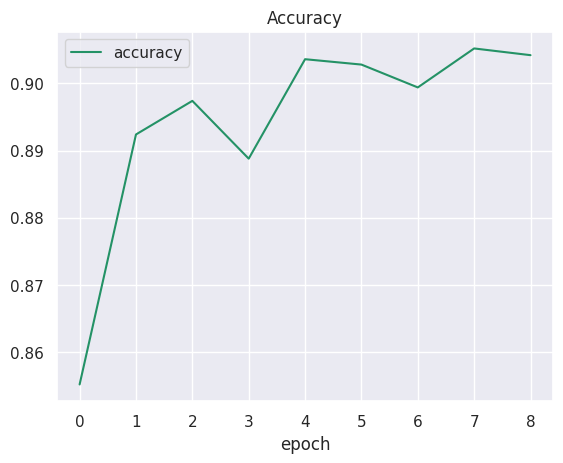

Лучшая accuracy: 90.52


In [48]:
model_more_layers = CharLM(
        hidden_dim=256, 
        vocab_size=len(vocab),
        num_layers=3, 
        aggregation_type='max',
        rnn=nn.RNN)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_more_layers.parameters())

losses, acc = train(model_more_layers, num_epoch=5)
plot_results(losses, acc)

### Вариант 2. Использовать модель с GRU

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.352, acc: 0.883


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.217, acc: 0.912


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.166, acc: 0.905


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.127, acc: 0.911


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.094, acc: 0.907


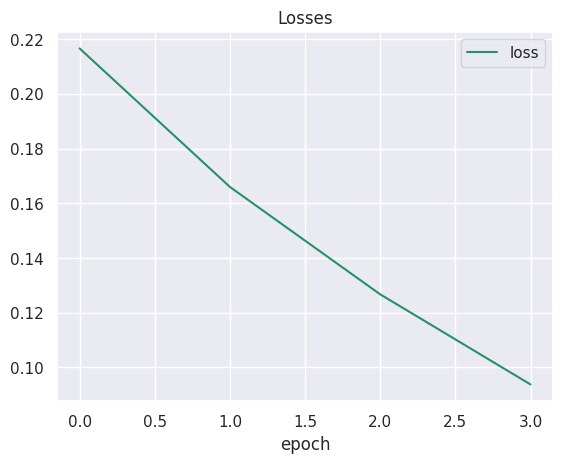

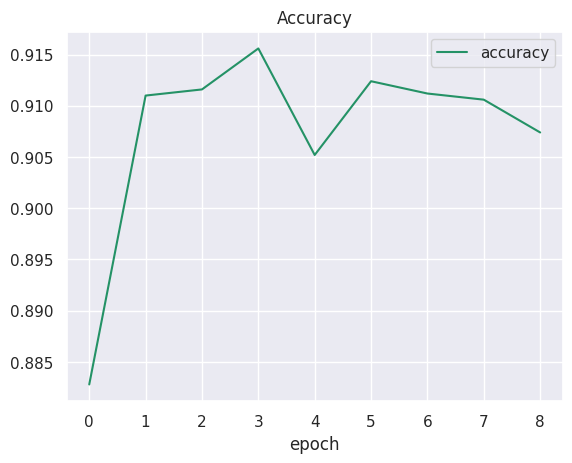

Лучшая accuracy: 91.56


In [54]:
model_gru = CharLM(
        hidden_dim=256, 
        vocab_size=len(vocab),
        num_layers=1, 
        aggregation_type='max',
        rnn=nn.GRU)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_gru.parameters())

losses, acc = train(model_gru, num_epoch=5)
plot_results(losses, acc)

### Вариант 3. Подбор гиперпараметров (увеличим hidden_dim)

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.426, acc: 0.868


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.319, acc: 0.888


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.289, acc: 0.886


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.265, acc: 0.898


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.253, acc: 0.898


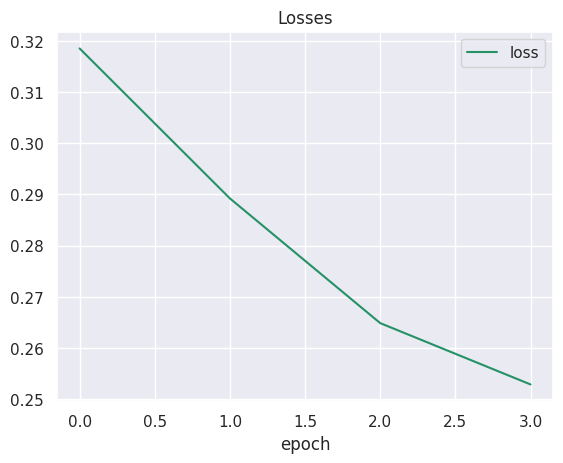

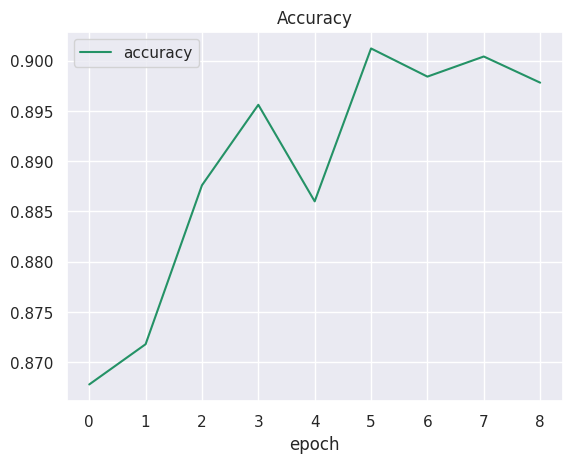

Лучшая accuracy: 90.12


In [51]:
model_bigger_hidden_size = CharLM(
        hidden_dim=512, 
        vocab_size=len(vocab), 
        num_layers=1,
        aggregation_type='max',
        rnn=nn.RNN)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_bigger_hidden_size.parameters())

losses, acc = train(model_bigger_hidden_size, num_epoch=5)
plot_results(losses, acc)

### Получение высокого качества (3 балла)

In [67]:
import pandas as pd

models = {
    'Модель из семинара (бейзлайн)': round(evaluate(model_base, eval_dataloader), 3),
    'Модель с бОльшим количеством рекуррентных слоев': round(evaluate(model_more_layers, eval_dataloader), 3),
    'Модель с реккурентным слоем GRU': round(evaluate(model_gru, eval_dataloader), 3),
    'Модель с бОльшим вектором скрытого состояния': round(evaluate(model_bigger_hidden_size, eval_dataloader), 3)
}

pd.DataFrame(models, index=['accuracy']).T.sort_values(by='accuracy')

,accuracy
Модель с бОльшим вектором скрытого состояния,0.895
Модель из семинара (бейзлайн),0.898
Модель с реккурентным слоем GRU,0.904
Модель с бОльшим количеством рекуррентных слоев,0.909


Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.

- Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
- Проанализируйте графики сходимости моделей в проведенных экспериментах
- Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
- Укажите, какая модель получилась оптимальной.

# Отчет:
- Увеличение количества рекуррентных слоев, а также замена обычного реккурентного слоя на слой с "памятью" дали улучшение качества. Увеличение размера вектора скрытого состяния, наоборот уменьшило качество.
- Все модели плохо сходятся, графики точности скачут, скорее всего, модели переобучаются
- Скачки точности при обучении в пределах 1 процента, что, на мой взгляд, существенно. Всем моделям не хватает стабильности.
- Модель с бОльшим количеством рекуррентных слоев в данном случае оказалась наиболее оптимальной.